In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.
Using gpu device 0: Quadro M4000 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

# Data loading and preparation

In [3]:
# load the dataset
dataframe = pd.read_csv('bike_sharing_day.csv')
dataframe = dataframe[['cnt']]
dataset = dataframe.values
dataset = dataset.astype('float32')

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

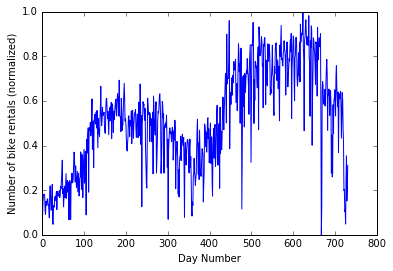

In [5]:
plt.plot(dataset)
plt.xlabel('Day Number')
plt.ylabel('Number of bike rentals (normalized)')
plt.show()

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Length of the training data: ' + str(len(train)) + ' and length of the test data: ' + str(len(test)))

Length of the training data: 511 and length of the test data: 220


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window), 0]
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
# reshape into X=t and Y=t+1
window = 1
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Defining the network

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0639
Epoch 2/100
1s - loss: 0.0191
Epoch 3/100
1s - loss: 0.0158
Epoch 4/100
1s - loss: 0.0135
Epoch 5/100
1s - loss: 0.0124
Epoch 6/100
1s - loss: 0.0122
Epoch 7/100
0s - loss: 0.0120
Epoch 8/100
0s - loss: 0.0120
Epoch 9/100
0s - loss: 0.0121
Epoch 10/100
1s - loss: 0.0120
Epoch 11/100
0s - loss: 0.0119
Epoch 12/100
1s - loss: 0.0121
Epoch 13/100
0s - loss: 0.0120
Epoch 14/100
0s - loss: 0.0120
Epoch 15/100
0s - loss: 0.0120
Epoch 16/100
0s - loss: 0.0121
Epoch 17/100
0s - loss: 0.0121
Epoch 18/100
0s - loss: 0.0121
Epoch 19/100
1s - loss: 0.0120
Epoch 20/100
1s - loss: 0.0120
Epoch 21/100
1s - loss: 0.0120
Epoch 22/100
0s - loss: 0.0120
Epoch 23/100
0s - loss: 0.0120
Epoch 24/100
1s - loss: 0.0120
Epoch 25/100
0s - loss: 0.0120
Epoch 26/100
0s - loss: 0.0119
Epoch 27/100
0s - loss: 0.0120
Epoch 28/100
0s - loss: 0.0120
Epoch 29/100
0s - loss: 0.0120
Epoch 30/100
0s - loss: 0.0119
Epoch 31/100
0s - loss: 0.0120
Epoch 32/100
1s - loss: 0.0120
Epoch 33/100
0s -

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 959.28 RMSE
Test Score: 1351.63 RMSE


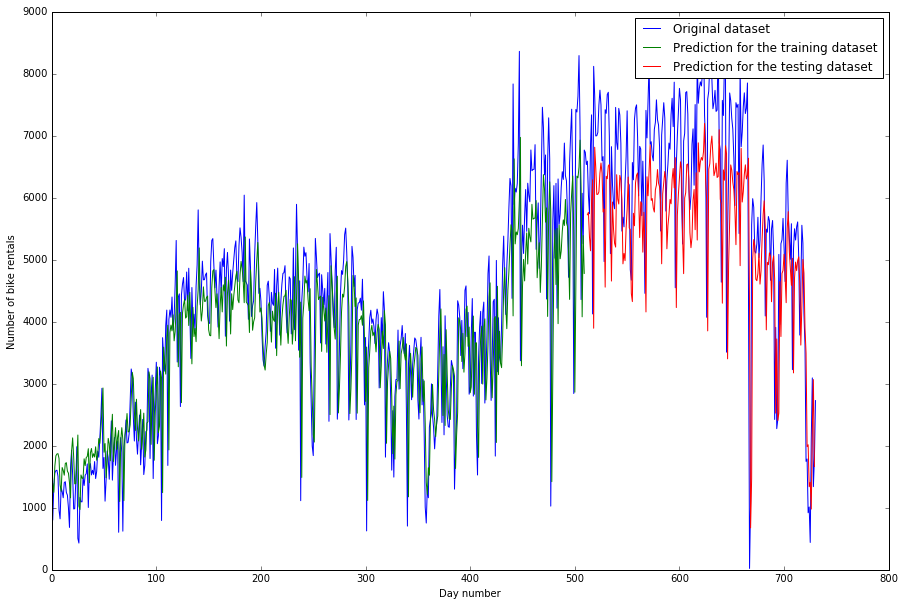

In [13]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(15, 10))
plt.plot(scaler.inverse_transform(dataset), label = 'Original dataset')
plt.plot(trainPredictPlot, label = 'Prediction for the training dataset')
plt.plot(testPredictPlot, label = 'Prediction for the testing dataset')
plt.xlabel('Day number')
plt.ylabel('Number of bike rentals')
plt.legend()
plt.show()